In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils.utils import *
from utils.kabsch2D import *
from nsd_access import NSDAccess 
from scipy import stats
from utils.flips import create_rotation_df, get_ranking, get_rank_dict
from utils.stats import rank_correlation, parametric_test, wilcoxon_test, plot_colorcoded
from scipy.spatial.distance import pdist

In [5]:
def all_subj_rank(dict, rois, random=True):
    """
    Take the dictionary containing the ranking for all participants and 
    return one final ranking, that is simply the sum of all rankings
    """
    if random:
        rank_total = np.zeros(len(rois) + 1)
    else:
        rank_total = np.zeros(len(rois))
    for i in range(len(dict)):
        rank_total += list(dict.values())[i]
    return rank_total

In [7]:

rank_dict, rank_dict_values = get_rank_dict(subj_list, rois, random=random, mode='averaged')

In [8]:
rank_total = all_subj_rank(rank_dict_values, rois)
rank_total.sort_values()

source
VO-1      5.046467
VO-2      5.134792
V3        5.242516
PHC-1     5.270800
hV4       5.271054
LO-1      5.280855
PHC-2     5.289833
TO-2      5.310410
V1        5.395471
LO-2      5.399963
V2        5.461472
TO-1      5.597116
random    6.962392
Name: distance, dtype: float64

In [9]:
rank_dict_values_norm = {key : (value) / (value.max()) for key, value in rank_dict_values.items()} #normalize with random
print(rank_dict_values_norm)
rank_total_norm = all_subj_rank(rank_dict_values_norm, rois)
print(rank_total_norm.sort_values())

{'subj01': source
VO-2      0.755494
hV4       0.764712
PHC-2     0.765413
V2        0.769307
VO-1      0.775515
LO-1      0.783133
PHC-1     0.783489
V1        0.788727
V3        0.793096
TO-2      0.816848
LO-2      0.829340
TO-1      0.860395
random    1.000000
Name: distance, dtype: float32, 'subj02': source
VO-1      0.743994
LO-1      0.751448
TO-2      0.763778
PHC-2     0.775733
TO-1      0.781330
V3        0.784659
LO-2      0.784966
VO-2      0.787962
V1        0.788483
V2        0.809553
hV4       0.812576
PHC-1     0.858298
random    1.000000
Name: distance, dtype: float32, 'subj03': source
PHC-1     0.654636
VO-2      0.666067
VO-1      0.668514
TO-2      0.693667
hV4       0.701157
V3        0.705846
V1        0.720183
LO-1      0.722678
V2        0.742286
PHC-2     0.744012
LO-2      0.764055
TO-1      0.788509
random    1.000000
Name: distance, dtype: float32, 'subj04': source
PHC-1     0.703211
PHC-2     0.706779
LO-1      0.726287
LO-2      0.733191
VO-1      0.733865

## KENDALL TAU CORRELATION TEST

In [8]:
corr_df, corr_ps = rank_correlation(rank_dict)
corr_df

,subj01,subj02,subj03,subj04,subj05,subj06,subj07,subj08
subj01,1.000000,0.076923,0.205128,-0.153846,-0.128205,0.051282,0.743590,0.435897
subj02,0.076923,1.000000,0.153846,0.102564,0.435897,0.512821,0.076923,0.128205
subj03,0.205128,0.153846,1.000000,-0.025641,0.000000,-0.179487,0.205128,0.102564
subj04,-0.153846,0.102564,-0.025641,1.000000,0.102564,0.282051,-0.205128,-0.102564
subj05,-0.128205,0.435897,0.000000,0.102564,1.000000,0.307692,-0.128205,-0.076923
subj06,0.051282,0.512821,-0.179487,0.282051,0.307692,1.000000,-0.051282,0.256410
subj07,0.743590,0.076923,0.205128,-0.205128,-0.128205,-0.051282,1.000000,0.435897
subj08,0.435897,0.128205,0.102564,-0.102564,-0.076923,0.256410,0.435897,1.000000


In [9]:
corr_ps

,subj01,subj02,subj03,subj04,subj05,subj06,subj07,subj08
subj01,0.00000,0.76502,0.36740,0.50977,0.59004,0.85773,0.00015,0.04218
subj02,0.76502,0.00000,0.50977,0.67543,0.04218,0.01495,0.76502,0.59004
subj03,0.36740,0.50977,0.00000,0.95236,1.00000,0.43538,0.36740,0.67543
subj04,0.50977,0.67543,0.95236,0.00000,0.67543,0.20437,0.36740,0.67543
subj05,0.59004,0.04218,1.00000,0.67543,0.00000,0.16349,0.59004,0.76502
subj06,0.85773,0.01495,0.43538,0.20437,0.16349,0.00000,0.85773,0.25186
subj07,0.00015,0.76502,0.36740,0.36740,0.59004,0.85773,0.00000,0.04218
subj08,0.04218,0.59004,0.67543,0.67543,0.76502,0.25186,0.04218,0.00000


## PARAMETRIC TEST

In [11]:
parametric_test(subj_list, rois, iterations=100) # run for all participants, choose your iterations
# saved as a csv because it take ages to run 

KeyboardInterrupt: 

In [6]:
subj_01_param = os.path.join(param_dir, 'subj01_parametric_test_output.csv')
subj_01_param = pd.read_csv(subj_01_param)
subj_01_param

FileNotFoundError: [Errno 2] No such file or directory: '/media/Working/stan-thesis/projects/stats/parametric_test/subj01_parametric_test_output.csv'

In [ ]:
plt.hist(subj_01_param.V1)
plt.show()

## WILCOXON TEST 

In [2]:
z_values_df_W, p_values_df_W, median_df_W = wilcoxon_test(subj_list, rois, mode='train')
z_values_df_W # check z values 

,V1,V2,V3,hV4,VO-1,VO-2,PHC-1,PHC-2,LO-1,LO-2,TO-1,TO-2
V1,0,0.786591,2.796235,-0.03837,4.014492,1.913719,1.021609,1.553997,-0.436462,-0.115111,-0.80098,0.249407
V2,-0.786591,0,1.971274,1.09835,3.016865,2.887365,0.431666,1.247035,0.330944,-0.330944,-0.872924,-0.259
V3,-2.796235,-1.971274,0,-1.462868,2.187107,-0.028778,-1.482053,0.172666,-0.997628,-1.347757,-2.004848,-1.381331
hV4,0.03837,-1.09835,1.462868,0,2.44131,2.426921,0.450851,0.652295,-0.139092,-0.681073,-1.218257,-0.585147
VO-1,-4.014492,-3.016865,-2.187107,-2.44131,0,-0.988035,-1.8082,-0.431666,-1.232646,-1.611552,-2.239866,-2.206292
VO-2,-1.913719,-2.887365,0.028778,-2.426921,0.988035,0,0.978443,-0.239814,-1.184683,-1.592367,-2.163126,-1.904126
PHC-1,-1.021609,-0.431666,1.482053,-0.450851,1.8082,-0.978443,0,1.050387,-0.527592,-0.853739,-1.573182,-1.112739
PHC-2,-1.553997,-1.247035,-0.172666,-0.652295,0.431666,0.239814,-1.050387,0,-2.690717,-3.275864,-4.849046,-2.119959
LO-1,0.436462,-0.330944,0.997628,0.139092,1.232646,1.184683,0.527592,2.690717,0,-2.153533,-3.208716,-0.93048
LO-2,0.115111,0.330944,1.347757,0.681073,1.611552,1.592367,0.853739,3.275864,2.153533,0,-1.184683,0.100722


In [3]:
median_df_W


,V1,V2,V3,hV4,VO-1,VO-2,PHC-1,PHC-2,LO-1,LO-2,TO-1,TO-2
V1,0,0.012716,0.02358,-0.012048,0.036895,0.008336,0.017559,0.015603,-0.002082,-0.010055,-0.025534,0.015002
V2,-0.012716,0,0.011913,0.006662,0.029208,0.021916,0.01217,0.032893,0.007435,-0.011122,-0.01873,-0.009268
V3,-0.02358,-0.011913,0,-0.016726,0.011733,-0.004303,-0.007307,0.003774,-0.022177,-0.053623,-0.0557,-0.009243
hV4,0.012048,-0.006662,0.016726,0,0.030945,0.011323,0.023196,0.017745,-0.003936,-0.020787,-0.029377,-0.000517
VO-1,-0.036895,-0.029208,-0.011733,-0.030945,0,-0.022621,-0.024958,-0.012801,-0.021965,-0.024649,-0.0427,-0.024048
VO-2,-0.008336,-0.021916,0.004303,-0.011323,0.022621,0,0.002216,-0.016967,-0.036265,-0.043782,-0.065132,-0.019133
PHC-1,-0.017559,-0.01217,0.007307,-0.023196,0.024958,-0.002216,0,0.005369,-0.024264,-0.031319,-0.026865,-0.020551
PHC-2,-0.015603,-0.032893,-0.003774,-0.017745,0.012801,0.016967,-0.005369,0,-0.025046,-0.032365,-0.041776,-0.014834
LO-1,0.002082,-0.007435,0.022177,0.003936,0.021965,0.036265,0.024264,0.025046,0,-0.01481,-0.011056,-0.003768
LO-2,0.010055,0.011122,0.053623,0.020787,0.024649,0.043782,0.031319,0.032365,0.01481,0,-0.003321,0.020095


In [4]:
p_values_df_W

,V1,V2,V3,hV4,VO-1,VO-2,PHC-1,PHC-2,LO-1,LO-2,TO-1,TO-2
V1,1,0.431521,0.00517,0.969392,0.00006,0.055656,0.306966,0.120185,0.662501,0.908357,0.423143,0.803046
V2,0.431521,1,0.048693,0.272052,0.002554,0.003885,0.665984,0.212385,0.740687,0.740687,0.382704,0.795636
V3,0.00517,0.048693,1,0.143504,0.028735,0.977042,0.138326,0.862914,0.31846,0.177737,0.044979,0.167177
hV4,0.969392,0.272052,0.143504,1,0.014634,0.015228,0.652097,0.514211,0.889377,0.495825,0.223126,0.558449
VO-1,0.00006,0.002554,0.028735,0.014634,1,0.323135,0.070575,0.665984,0.217708,0.107059,0.0251,0.027364
VO-2,0.055656,0.003885,0.977042,0.015228,0.323135,1,0.327855,0.810474,0.236143,0.111302,0.030532,0.056894
PHC-1,0.306966,0.665984,0.138326,0.652097,0.070575,0.327855,1,0.29354,0.597783,0.39325,0.115677,0.265821
PHC-2,0.120185,0.212385,0.862914,0.514211,0.665984,0.810474,0.29354,1,0.00713,0.001053,0.000001,0.03401
LO-1,0.662501,0.740687,0.31846,0.889377,0.217708,0.236143,0.597783,0.00713,1,0.031277,0.001333,0.352123
LO-2,0.908357,0.740687,0.177737,0.495825,0.107059,0.111302,0.39325,0.001053,0.031277,1,0.236143,0.919771


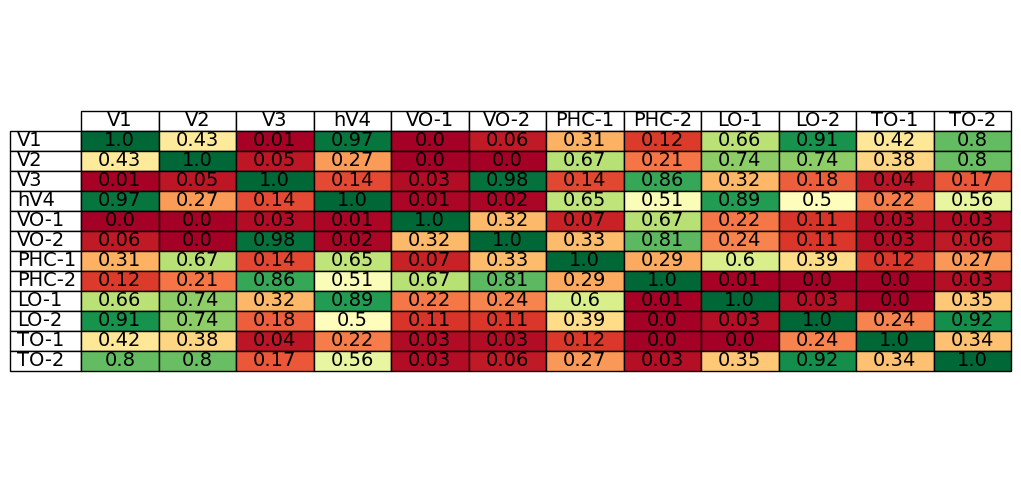

In [7]:
plot_colorcoded( p_values_df_W.apply(pd.to_numeric))

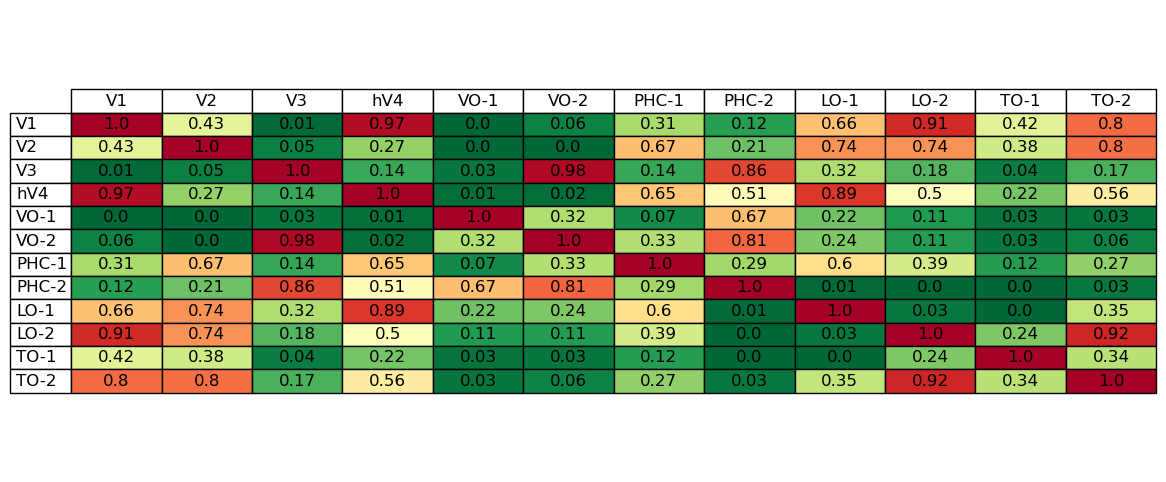

In [12]:
df = p_values_df_W.apply(pd.to_numeric)
norm = plt.Normalize(df.values.min(), df.values.max())

# Create a custom colormap
cmap = plt.get_cmap('RdYlGn')

# Create a figure and a single subplot
fig, ax = plt.subplots(figsize=(10, 6))

# Hide the axes
ax.axis('tight')
ax.axis('off')

# Create a table with colored cells
cell_colors = cmap(1-norm(df.values))

# Add table to the axes
table = ax.table(cellText=df.values.round(2),
                 rowLabels=df.index,
                 colLabels=df.columns,
                 cellColours=cell_colors,
                 cellLoc='center',
                 loc='center')

# Customize the table appearance
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.4, 1.4)

# Display the plotS
plt.show()

In [7]:
p_values_df_W

,V1,V2,V3,hV4,VO-1,VO-2,PHC-1,PHC-2,LO-1,LO-2,TO-1,TO-2
V1,1,0.044979,0.335019,0.349646,0.0,0.690562,0.09321,0.900758,0.43716,0.495825,0.159928,0.286977
V2,0.044979,1,0.143504,0.06275,0.000001,0.001977,0.000919,0.129614,0.46598,0.286977,0.634906,0.001186
V3,0.335019,0.143504,1,0.648644,0.0,0.448563,0.09321,0.859145,0.43716,0.511122,0.157096,0.168656
hV4,0.349646,0.06275,0.648644,1,0.003332,0.112383,0.130832,0.954103,0.398588,0.337429,0.12483,0.34718
VO-1,0.0,0.000001,0.0,0.003332,1,0.043963,0.008108,0.026373,0.003436,0.004191,0.001206,0.085094
VO-2,0.690562,0.001977,0.448563,0.112383,0.043963,1,0.352123,0.648644,0.128405,0.200331,0.066213,0.726242
PHC-1,0.09321,0.000919,0.09321,0.130832,0.008108,0.352123,1,0.170145,0.009465,0.039169,0.007659,0.367215
PHC-2,0.900758,0.129614,0.859145,0.954103,0.026373,0.648644,0.170145,1,0.44284,0.177737,0.000709,0.59114
LO-1,0.43716,0.46598,0.43716,0.398588,0.003436,0.128405,0.009465,0.44284,1,0.564916,0.002213,0.048147
LO-2,0.495825,0.286977,0.511122,0.337429,0.004191,0.200331,0.039169,0.177737,0.564916,1,0.000067,0.111302


In [17]:
# apply rotation on one subject
def apply_rotation(target, subj, rois, sessions):
    # obtain the rotation matrix again
    rotations_df = create_rotation_df(subj, rois, sessions)
    rotations_df = rotations_df[rotations_df['base'] == target]
    indx_to_keep = rotations_df.groupby(['source', 'base'])['distance'].idxmin()
    rotations_df = rotations_df.loc[indx_to_keep]
    rotations_df = rotations_df.reset_index(drop=True)
    print(rotations_df.U)
    rotated_path = os.path.join(proj_dir, 'MDS_rotated', subj)
    print(rotated_path)
    if not os.path.exists(rotated_path):
        os.makedirs(rotated_path)
        print(os.path.exists(rotated_path))
    for roi in rois.keys():
        source_mds = np.load(f'/home/stan/thesis-repo/data/MDS/{subj}/{subj}_{sessions}_{roi}_mds_betas_train.npy', allow_pickle=False)
        mds_rotated_file = os.path.join(rotated_path, f'{subj}_{sessions}_{roi}_mds_betas_train_rotated_{target}.npy')
        # if the source is our reference point, just save it without applying rotation
        if roi == target:
            if not os.path.exists(mds_rotated_file):
                np.save(mds_rotated_file, source_mds, allow_pickle=True)
            continue 
        U = rotations_df.loc[rotations_df['source'] == roi, 'U'].squeeze()
        mds_rotated = np.dot(source_mds, U)  # apply rotation with dot product
        if not os.path.exists(mds_rotated_file):
            np.save(mds_rotated_file, mds_rotated, allow_pickle=True)
    
    

In [18]:
for i in range(1, 9):
    apply_rotation('PHC-1', f'subj0{i}', rois, sessions[i-1])


0     [[0.3854254, -0.9227389], [0.9227389, 0.3854254]]
1     [[-0.7893548309175643, -0.613937253232856], [0...
2     [[0.98475903, 0.17392436], [-0.17392436, 0.984...
3     [[0.86215484, -0.50664485], [0.50664485, 0.862...
4     [[-0.98772126, -0.15622663], [0.15622663, -0.9...
5     [[-0.6911771960423665, 0.7226853282522155], [-...
6     [[0.65729177, -0.75363624], [0.75363624, 0.657...
7     [[0.7329165, -0.6803186], [0.6803186, 0.7329165]]
8     [[0.13863223248103285, 0.9903439322363339], [-...
9     [[-0.6130681307201219, -0.7900300418941899], [...
10    [[-0.7989624207084763, -0.6013809527210279], [...
Name: U, dtype: object
/home/stan/thesis-repo/projects/NSD/MDS_rotated/subj01
0     [[-0.19842188, -0.9801167], [0.9801167, -0.198...
1     [[0.99857616, -0.053343683], [0.053343683, 0.9...
2     [[0.91326874, 0.40735754], [-0.40735754, 0.913...
3     [[0.9951258, 0.09861478], [-0.09861478, 0.9951...
4     [[-0.610746865004843, 0.7918259069307825], [-0...
5     [[-0.87343055, 0.486

In [19]:
# for all of rotated MDS: try to center them? Find the highest value from 0 